In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

# Load transect densities from Soviet NP data

In [2]:
ef = pd.ExcelFile('../data/transect_densities.xlsx')

sns  = ef.sheet_names

dfs = []

for sn in sns:
    
    df = pd.read_excel('../data/transect_densities.xlsx',sheet_name=sn)
    
    dfs.append(df)
    
len(dfs)

24

# Calculate mean density of each transect, and append to list along with day of year the transect was done on

In [3]:
mean_densities = []

measurement_counter = 0

for df in dfs:
    
#     print(df)
    
    for col in df.columns[1:]:
        
        count = np.count_nonzero(np.nan_to_num(df[col]))
        measurement_counter+=count

        mean_densities.append( {'doy':col.timetuple().tm_yday,
                                    'den': np.nanmean(df[col])*1000,
                                    }
                                )
        
print(measurement_counter)

4588


/tmp/ipykernel_4386/953706897.py:15: RuntimeWarning: Mean of empty slice
  'den': np.nanmean(df[col])*1000,


In [5]:
len(mean_densities)

580

# Turn into dataframe and visualise evolution of transect mean density

In [10]:
df = pd.DataFrame(mean_densities)

print(df[df['den']<100])
print()
print(df[df['den']>500])

df = df[df['den']>100]
df = df[df['den']<500]

df

    doy        den
99  263  25.714285

     doy         den
135  201  549.999992
136  232  526.666661
406  169  569.999993
407  179  668.000007


,doy,den
0,151,299.000001
1,162,334.000003
2,174,368.749999
3,185,385.999998
4,314,264.999998
...,...,...
575,51,328.000003
576,59,341.000003
577,69,346.000004
578,79,348.000005


# Make data continuous over 1st January, by shifting the discontinuity to 1st August

In [11]:
datetime.date(2001,8,1) - datetime.date(2001,1,1)

datetime.timedelta(days=212)

In [13]:
day_thresh = 242 #1 September
day_thresh = 212 #1 August

df['doy_adj'] = [d-365 if d>day_thresh else d for d in df['doy']]

# Generate x-ticks and x-ticks label

In [14]:
month_start_doys = [0]
counter = 0
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

month_names = [mn+ ' 1' for mn in month_names]
for d in [31,28,31,30,31,30,31,31,31,31,30]:
    counter +=d
    month_start_doys.append(counter)

xticks = [d-365 if d>=day_thresh else d for d in month_start_doys]

In [15]:
sorted(zip(xticks,month_names))

[(-153, 'Aug 1'),
 (-122, 'Sep 1'),
 (-91, 'Oct 1'),
 (-60, 'Nov 1'),
 (-30, 'Dec 1'),
 (0, 'Jan 1'),
 (31, 'Feb 1'),
 (59, 'Mar 1'),
 (90, 'Apr 1'),
 (120, 'May 1'),
 (151, 'Jun 1'),
 (181, 'Jul 1')]

# Plot the data over the winter season

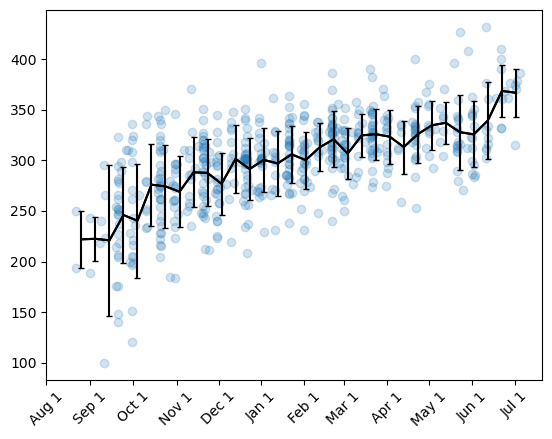

In [16]:
bins = np.arange(day_thresh-365,day_thresh+1,10)            

means, bin_edges, bn = binned_statistic(df['doy_adj'],
                                            df['den'],
                                            bins=bins,
                                            statistic='mean')
       
stds, bin_edges, bn = binned_statistic(df['doy_adj'],
                                            df['den'],
                                            bins=bins,
                                            statistic='std')

            
    
plt.scatter(df['doy_adj'], df['den'],alpha=0.2)

plt.plot(bins[:-1]+5,means,color='k')
plt.errorbar(x=bins[:-1]+5,y=means,yerr=stds,color='k',capsize=2)

plt.xticks(xticks,labels=month_names,rotation=45)
plt.show()

# Fit a 1st order polynomial to the data.

Turns out that this is basically the same as fitting a 2 or 3rd order one! Line only curves when you get to 4th order.

In [18]:
def den_from_doy(doy):
    if doy>day_thresh:
        doy_adj = doy-365
    else:
        doy_adj = doy
        
    den = p[0] + p[1]*doy_adj
    
    return den

In [22]:
m20_mon = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr']
m20_mon_nums = [10,11,12,1,2,3,4]

mon_densities = {}
for t,mon in zip(range(0,8),m20_mon_nums):
    den = 6.5*t + 274.5
    mon_densities[mon] = den

day_bands = {}
for mon in m20_mon_nums:
    
    first_day = datetime.date(2023,mon,1).timetuple().tm_yday
    if mon != 12:
        last_day = datetime.date(2023,mon+1,1).timetuple().tm_yday-1
    else:
        last_day = 1
        
    if first_day >213:
        first_day = first_day-365
    if last_day >213:
        last_day = last_day-365
        
    day_bands[mon] = (first_day,last_day)

In [32]:
from scipy.stats import linregress
lr = linregress(x,y)
r_val = str(np.round(lr[2],decimals=2))
r_val, df.shape

('0.62', (573, 3))

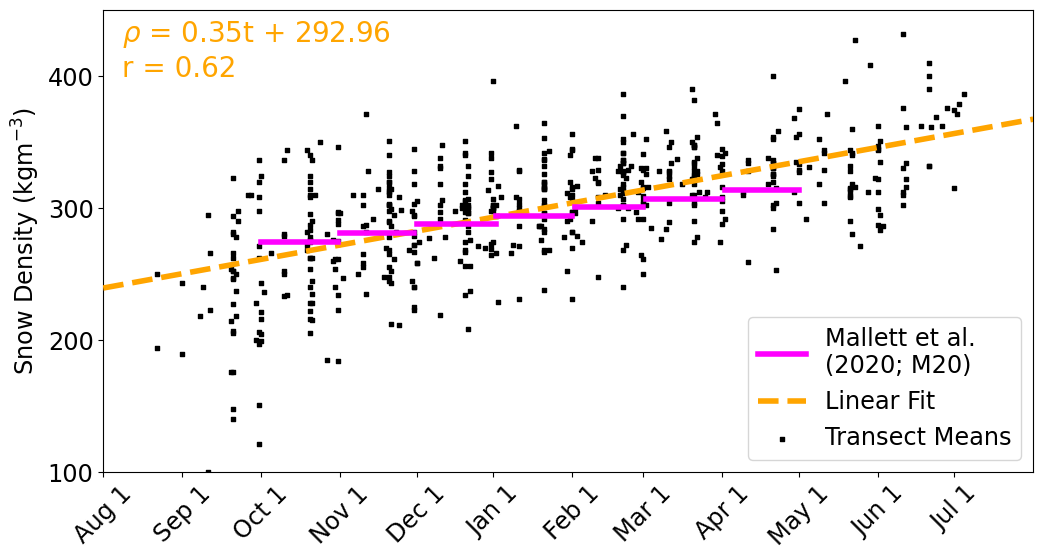

 
0.3504 x + 293


In [35]:
x = df['doy_adj']
y = df['den']
z = np.polyfit(x,y,1)

p = np.poly1d(z)

c1='magenta'
c2='orange'
c3='k'

plt.figure(figsize=(12,6))

for key in day_bands.keys():
    plt.plot([day_bands[key][0],day_bands[key][1]],
             [mon_densities[key],mon_densities[key]],
            color=c1,lw=4,zorder=10)
    
plt.plot([],
         [],
         label='Mallett et al.\n(2020; M20)',
        color=c1,lw=4,zorder=10)


xs2 = [day_thresh-365,day_thresh]
dp2 = [den_from_doy(d) for d in xs2]



plt.plot(xs2,dp2,color=c2,label='Linear Fit',
         zorder=5,lw=4,linestyle='--')



plt.scatter(x,y,
            marker='s',
            s=7,
#             alpha=0.1,
            color=c3,
            label='Transect Means')

plt.xticks(xticks,labels=month_names,
           rotation=45,fontsize='xx-large')

plt.yticks(np.arange(100,501,100),fontsize='xx-large')

plt.legend(loc='lower right',fontsize='xx-large')


plt.ylabel('Snow Density (kgm$^{-3}$)',fontsize='xx-large')

r_str = f'\nr = {r_val}'

plt.annotate(fr'$\rho$ = {np.round(p[1],decimals=3)}t + {np.round(p[0],decimals=2)}'+r_str,
             xy=(0.02,0.98),xycoords='axes fraction',
             fontsize=20,color=c2,va='top')

odir = '/home/robbie/Dropbox/Apps/Overleaf/Densification/figs/'

plt.savefig(f'{odir}fig1.jpg',bbox_inches='tight',dpi=400)

plt.xlim(212-365,212)
plt.ylim(100,450)

plt.show()

print(p)

LinregressResult(slope=0.35044879378942506, intercept=292.95625140000385, rvalue=0.6170430423789074, pvalue=2.047472935300083e-61, stderr=0.018703669850318422, intercept_stderr=1.502886550638946)